# Chapter 10     
# Simulation as a Road to Insight   

## Introduction

Simulation enables data scientists to study the behavior of stochastic processes with complex probability distributions. Simple processes might be approximated by a known, or 'named' distribution. In these simple cases, it might even be possible to derive analytical results. However, most real-world processes have complex behavior, resulting in complex distributions of output values. In these cases, simulation is a practical approach to understanding these processes. The two main purposes of simulation can be summarized as:       
- **Testing models:** If data simulated from the model do not resemble the original data, something is likely wrong with the model.     
- **Understand processes with complex probability distributions:** In these cases, simulation provides a powerful and flexible computational technique to understand behavior.      

As cheap computational power has become ubiquitous, simulation has become a widely used technique in the data scientist's toolbox. Simulations compute a large number of cases or realizations. The computing cost of each realization must be low in any practical simulation.   

The realizations are drawn from complex probability distributions of the process being studied. In many cases, the realizations are computed using conditional probability distributions. The final or posterior distribution of the process being simulated is comprised of these realizations.     

## Creating simulations

Creating, testing and debugging simulation software is tricky    

- Techniques which can make your life easier are the same as you would use when developing any analytical software    

- Given the stochastic nature of simulation, testing, and debugging can be more difficult than other types of software      

- Some commonly employed techniques which will help you include:     
  - Build your simulation as a series of small, easily tested chunks    
  - Overall simulation comprises many of these small chunks, typically in the form of functions       
  - Test each small functional unit individually    
  - Tests should include at least some typical cases, as well as boundary or extreme cases   
  - Test your overall simulation each time you add a new functional component; attempts at *'big bang'* integration typically end in failure   
   
- Simulations are inherently stochastic    
  - Stochastic simulations are based on random sampling from appropriate distributions. The principles of sampling and the underlying random number generation are discussed in Chapter 9.    
  - If you want to create identical numerical results set a seed before you begin tests   
  - It is impossible to create and maintain quality simulation code without having detailed reproducible test cases
  
  

## The Scenario

Simulation employs several key concepts; conditional probability distributions and sampling theory. In this chapter, you will perform a series of exercises to simulate the profitability of a sandwich shop. Not surprisingly, the sandwich shop earns money every time a customer buys a sandwich. However, the inputs to the sandwich cost money. The daily profit is the amount customers pay for the sandwiches minus the costs of the inputs.    

The cost of bread is an input which is particularly difficult to manage. The shop bakes its own bread before it opens, and the bread must be used on the day it is made. The customers can select one of three types of bread, white, wheat, and multigrain. The customers are unusually picky. If the shop does not have the bread of the customer's choice available, the customer will leave the shop without buying a sandwich. However, any extra bread left at the end of the day is discarded, and the cost reduces the profitability of the shop.     

To keep this simulation simple, several assumptions are made:     
- The number of customers arriving at the shop each day is stationary with time and known to have a mean rate of 100 per day.    
- The probability that each customer chooses a particular type of bread is stationary and known. These probabilities are 50% for white bread, 25% for wheat, and 25% for multigrain.    
- If a customer's choice of bread is not available the customer leaves the shop without buying a sandwich.    
- If the customer buys a sandwich the mean profit to the shop is $1.00$.    
- The only perishable input which must be discarded at the end of each day is the bread. The discarded bread has a cost of $0.25$.    
- Customers do not stop coming to the sandwich shop as a result of not finding their bread choice. In other words, the number of arrivals is independent of how many customers actually buy a sandwich.    

From this problem description, it is clear there is a trade-off between the profitability of the shop and the amount of bread baked. If the shop manager orders too little bread, opportunities for profitable sandwich sales are lost. On the other hand, over-production of bread leads to loss of profit from the waste.    

In reality, these are questionable assumptions, and a real-world situation would be more complex. The simulation techniques used here can be applied to much more complex and realistic simulations.   

### Representation as Directed Acyclic Graphical Model

When creating a simulation with multiple conditionally dependent variables it is useful to draw a directed graph. Such a representation is known as a **directed acyclic graphical model or DAG** The graph is a communications device showing which variables are independent and which are conditionally dependent on others. The shapes used in the graph help with understanding.     
1. **Probability distributions** of the variables are shown as ellipses. Conditional distributions have **directed edges** leading to them, which specify the dependencies. These distributions have parameters that must be estimated.          
2. **Decision variables** are deterministic and are shown as rectangles. Decisions are determined by variables. Setting decision variables can be performed either manually or automatically.         
3. **Utility nodes**, profit, in this case, are shown as diamonds. These nodes represent a **utility function** given the dependencies in the graphs. Utility calculations are deterministic given the input values.        
4. **Directed edges** show the dependency structure of the distributions. The arrows point to **child nodes** which are dependent on **parent nodes** where the arrows originate.    

Values of decision variables are selected to optimize the utility. The directed graph for this simulation is shown in the figure below.    

<img src="images/Simulation_Directed_Graph.JPG" alt="Drawing" style="width: 600px;"/>

> **Exercise 10-1:** Answer the following questions about the graph:     
> 1. Which random variables are independent in the graph? 
> 2. Are the independent random variables the only ones for which parameters must be estimated or known apriori?   
> 3. Which are the dependent random variable(s) in the graph?    
> 4. Which is the decision variable?    
> 5. Given the values of the other variables, is profit deterministic, and why?      

> **Answers:**      
> 1. P(Arrivals) and P(Bread Choice) per defined.    
> 2. No, other variables in the graph, such as the conditional probability distribution P(Bread Demand | Arrivals, Bread Choice), also require parameters. These conditional probabilities depend on the independent variables and must be estimated based on the data or assumptions.               
> 3. P(Bread Demand | Arrivals, Bread Choice) and Profit.                 
> 4. Bread-Baked, which represents the amount of bread that the shop decides to bake each day.     
> 5. Yes, profit is deterministic given the values of the other variables. Once all the other variables are known profit can be directly calculated from these. There is no randomness involved in this calculation if all input variables are known, making the profit deterministic.

## Realizations of Distribution

The ability to compute large numbers of realizations from probability distributions is fundamental to simulation. Several questions naturally arise.     
1. Which distribution to choose? The answer to this question is typically determined through a combination of domain knowledge and significant data exploration. Usually, several choices are tested and compared.     
2. Are the distributions of the variables conditionally dependent? That is, do we need to know the distribution of some **parent variable** before we can compute the distribution of a **dependent child variable**.    
3. How are the parameters of the distributions determined? Typically, maximum likelihood estimation is applied to observations of the process to be simulated. If the process is non-stationary more complex methods, beyond the scope of our discussion, are required.     
4. How many realizations are required? The answer will depend on the accuracy you require from your simulation and how patient you are. Typically, some tests will indicate an appropriate number of realizations.     

The following code loads the suggested packages and configures the Seaborn graphics style.    

In [1]:
## Load packages we will need
import numpy as np
import numpy.random as nr
import pandas as pd
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns   
# Configure default plot style.
sns.set_palette('muted')
sns.set_style('ticks')


## Building the Simulation

Follow the steps in this section to build, test, and evaluate a simulation of sandwich shop profitability. The goal is to build a simple decision tool that will help the shop manager determine how much bread to bake each day.      

> **Coding note:** The exercises described in this section lead to the construction of simulation using functions. This approach has some advantages for statistical computing since there is a natural correspondence with statical functions. However, this approach can lead to awkward function calls with a great many arguments. Some encapsulation inherent in an object model reduces this complexity. If you have skills in object oriented design, you may wish to undertake these exercises using an object system.    

### Poisson Distribution for Arrival Rates

Poisson distributions are often used to model arrival processes. The Poisson distribution has a single parameter, the arrival rate or intensity, $\lambda$, per time period. We have reviewed key properties of the Poisson distribution in Chapter 7. We can express the density function of arrivals as:    

$$f(arrivals) = Pos(\lambda)$$

> **Exercise 10-2:** You will now create and test a function, named `customer_arrivals`, to simulate the daily number of customer arrivals at the sandwich shop. The argument to this function is the mean arrival rate and the function should return the integer number of arrivals for each daily realization. Include some test cases for your function. Your test function should generate 1000 realizations of 4 values of $\lambda$, in a range 1 to 1000, and for each of these values print the mean and variance and display a histogram of the realizations of an axes array. Then, write a short explanation of your test cases.       

Lambda: 1
Mean of arrivals: 0.958
Variance of arrivals: 0.9242359999999998




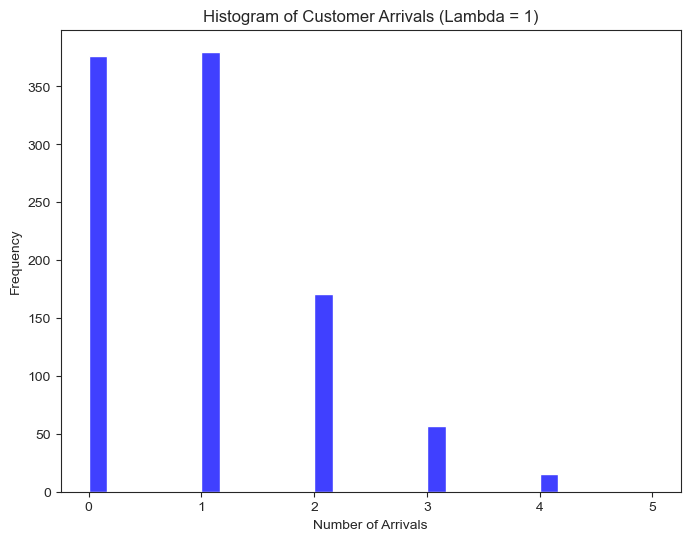

Lambda: 5
Mean of arrivals: 4.971
Variance of arrivals: 4.778159




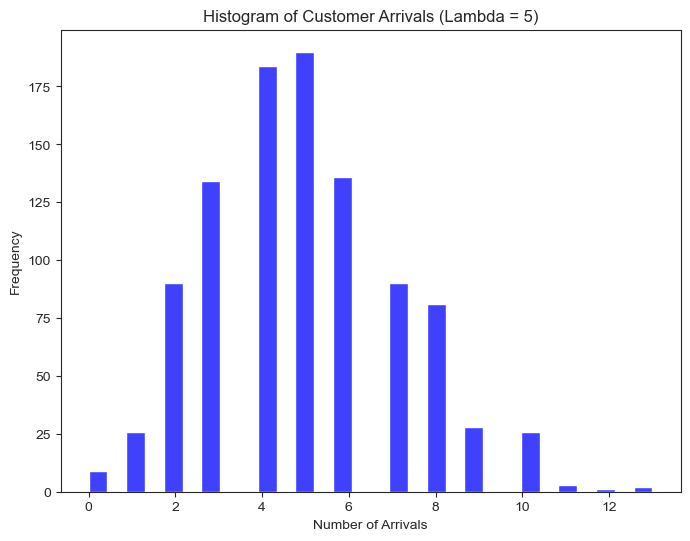

Lambda: 10
Mean of arrivals: 9.997
Variance of arrivals: 10.078991000000002




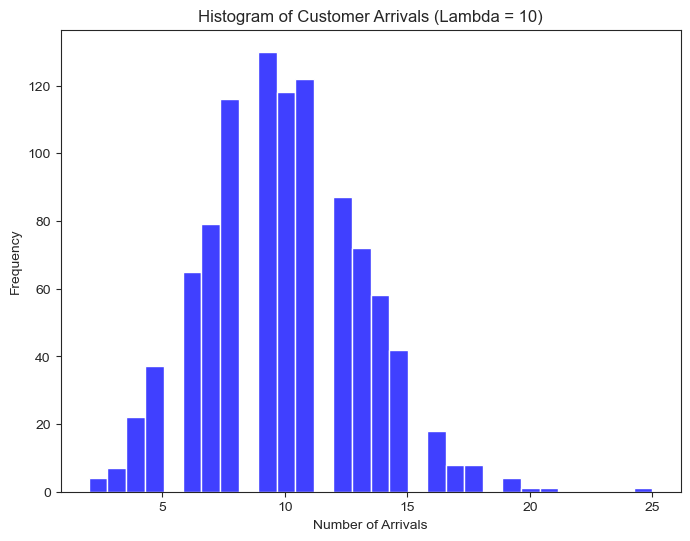

Lambda: 500
Mean of arrivals: 499.018
Variance of arrivals: 497.849676




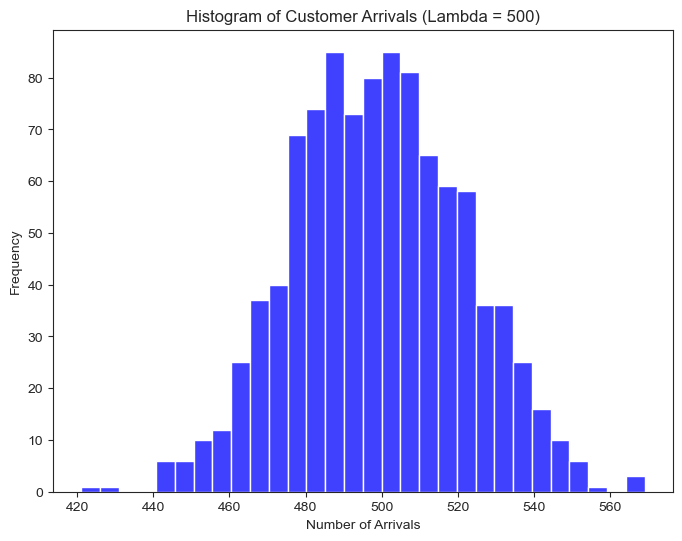

In [10]:
def customer_arrivals(lam):
    """
    Simulate the number of customer arrivals for a given mean arrival rate (lambda).
    
    Parameters:
    lam (int or float): Mean arrival rate.
    
    Returns:
    int: Number of customer arrivals for one realization.
    """
    return np.random.poisson(lam)

# Test cases for the function
lambdas = [1, 5, 10, 500]

# Storing results
results = {}

for lam in lambdas:
    # Generate 1000 realizations
    arrivals = [customer_arrivals(lam) for _ in range(1000)]
    results[lam] = arrivals
    print(f"Lambda: {lam}")
    print(f"Mean of arrivals: {np.mean(arrivals)}")
    print(f"Variance of arrivals: {np.var(arrivals)}")
    print("\n")
    
    # Plot histogram of arrivals
    plt.figure(figsize=(8, 6))
    sns.histplot(arrivals, kde=False, bins=30, color='blue')
    plt.title(f"Histogram of Customer Arrivals (Lambda = {lam})")
    plt.xlabel("Number of Arrivals")
    plt.ylabel("Frequency")
    plt.show()

> **Answer:**
>
> We simulate 1000 customer arrivals based on a mean arrival rate over 4 simulations, so we expect the mean to equal lambda in each case.
>
> For lambda = 1, since the mean arrival rate is 1, the Poisson distribution should generate a small number of arrivals per day. The mean and variance should both be close to 1 and we see this above.
>
> For lambda = 5, since the  mean arrival rate of 5, we should expect more frequent arrivals, typically between 3 and 7. The mean and variance should both be close to 5 as we see above.
>
> For lambda = 10 amd 500, the logic is similar to lambda = 1 and 5 and for larger lambdas such as 500, a normal distribution is starting to show more clearly.

### Simulate bread choice

The demand for the bread is simulated from a **categorical distribution**. Recalling the discussion in Chapter 7, for each customer arrival a choice of bread is made with probabilities, $\Pi = [\pi_1, \pi_2, \pi_3] = [0.5, 0.25, 0.25]$, for $[white, wheat, multigrain]$. We express density function of bread choice as:   

\begin{align}
f(white, wheat, multigrain) = Cat(\Pi)\\
\Pi = [\pi_1, \pi_2, \pi_3]
\end{align}

> **Exercise 10-3:** Create and test a function, named `bread_choice`, to simulate arriving customers' bread demand. The function takes three arguments, the number of arrivals, a list of bread choices, and the probabilities of those choices. The function returns a bread choice as a Numpy array of strings. Include some test cases for your function as follows:   
> 1. Create an array with the probabilities for the test cases in the rows. The first test case should be the default probabilities $[0.5,0.25,0.25]$. Create at least 3 other test cases with some extreme probability values, such as 0.0, 0.9, etc.    
> 2. For 100 arrivals, compute the bread choice array and use [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) to display a bar chart of the outcomes on a Matplotlib axes grid. Include a title so you can tell the cases apart. Set a [numpy.random.seed](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html) so your test cases are reproducible.  



> **Computational Note:** To create the function described you should use the [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) function on the list of bread choices. The size argument is the number of customer arrivals, in this case. Thus, all the bread choices for a given day are made with one function call. In general, computing a vector of results with a single call is a computationally efficient approach. Many computational libraries, including Numpy, are optimized for **vectorized** calls.    

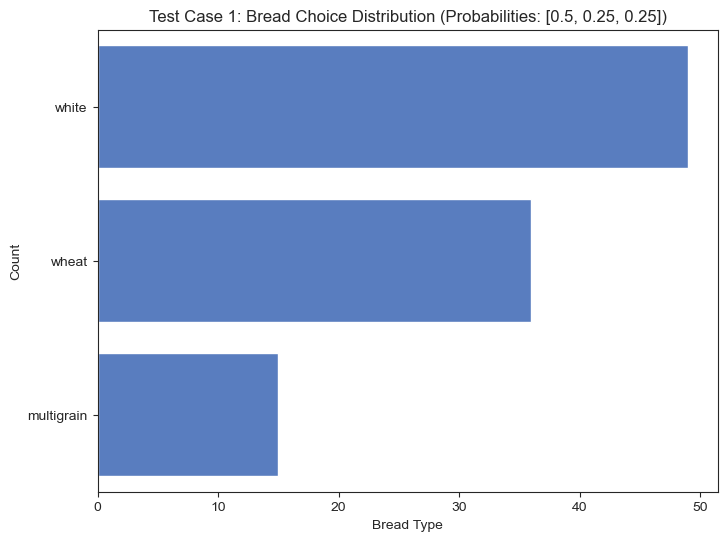

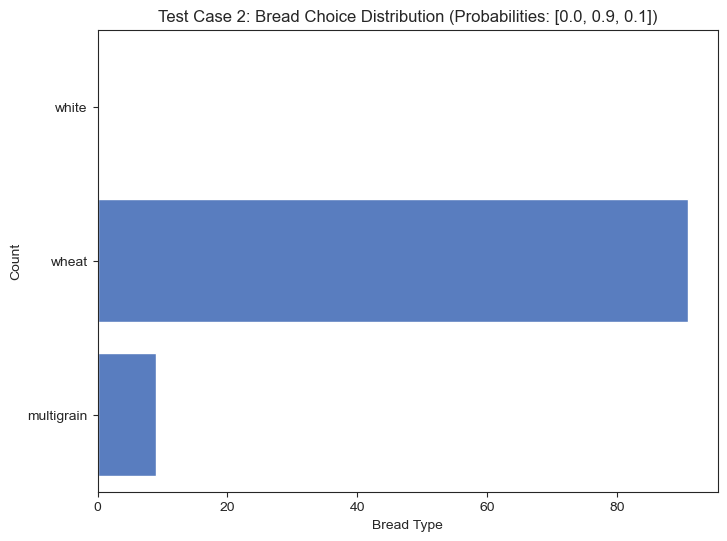

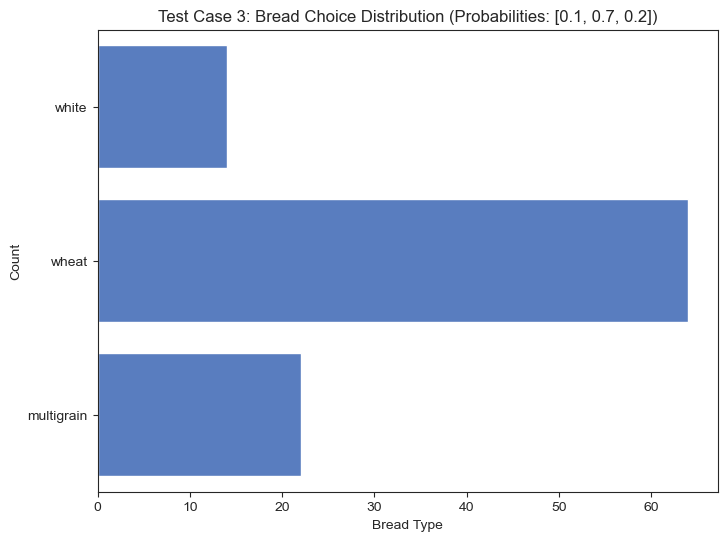

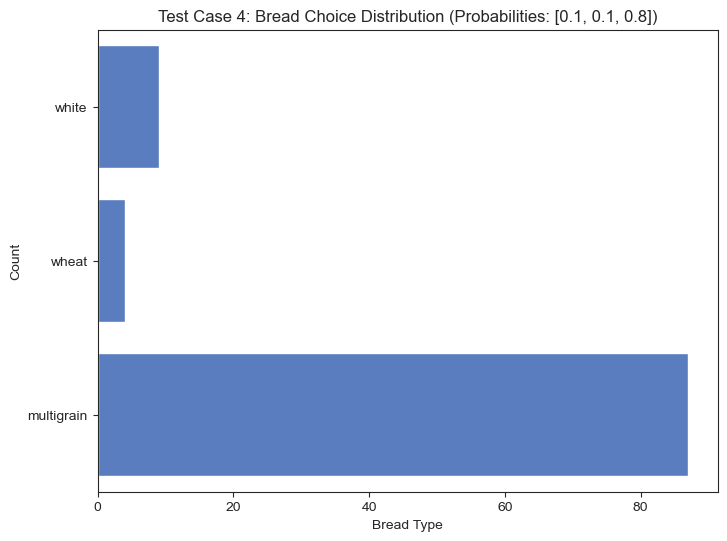

In [11]:
def bread_choice(num_arrivals, choices, probabilities):
    """
    Simulate the bread choice of customers.
    
    Parameters:
    num_arrivals (int): The number of customer arrivals.
    choices (list of str): The list of bread choices.
    probabilities (list of float): The probabilities associated with each bread choice.
    
    Returns:
    numpy.ndarray: Array of bread choices for each customer arrival.
    """
    return np.random.choice(choices, size=num_arrivals, p=probabilities)

# Set a seed for reproducibility
np.random.seed(123)

# Define bread choices
choices = ['white', 'wheat', 'multigrain']

# Define 4 test cases with different sets of probabilities
test_cases = [
    [0.5, 0.25, 0.25],
    [0.0, 0.9, 0.1],
    [0.1, 0.7, 0.2],
    [0.1, 0.1, 0.8]
]

# Define the number of arrivals
arrivals = 100

# Loop through each test case, simulate bread choices, and plot the results
for i, probabilities in enumerate(test_cases):
    bread_choices = bread_choice(arrivals, choices, probabilities)
    
    # Plot the outcomes
    plt.figure(figsize=(8, 6))
    sns.countplot(bread_choices, order=choices)
    plt.title(f"Test Case {i+1}: Bread Choice Distribution (Probabilities: {probabilities})")
    plt.xlabel('Bread Type')
    plt.ylabel('Count')
    plt.show()

> Keeping in mind that the outcomes of your tests are based on a randomly generated sample, does your function pass your tests?   

> **Answer:**  Yes, it passes in the probabilities and returns with np.random.choice. Here I set a seed to ensure reproducibility and the results seem to be close to the probabilities in the cases, albeit still with some variance.             

### Simulate bread demand

Before you can compute daily profitability you must simulate bread demand for each day. The probabilities of demand for each type of bread are conditional on the number of arrivals and the bread choices. In mathematical terms we can write this relationship as $P(demand\ |\ arrivals, choice)$. 

> **Exercise 10-4:** To compute this conditional distribution, you will write a function `bread_demand` with arguments of the mean arrival rate of customers, the choices of bread, and the probabilities of bread choice. Thia function computes the conditional distribution, $P(bread\ demand | customer\ arrivals, bread\ choice)$, using the `customer_arrivals` and `bread_choice` functions. The function will return a Numpy array of demand by bread type. Include 10 test cases, using $probabilities = [0.5,0.25,0.25]$ for white, wheat and multigrain bread choice, from which you print the total bread demand and the demand by bread type for 20 average arrivals. 

In [12]:
def bread_demand(mean_arrival_rate, choices, probabilities):
    """
    Simulate the daily bread demand based on customer arrivals and bread choices.
    
    Parameters:
    mean_arrival_rate (int or float): The mean arrival rate of customers.
    choices (list of str): The list of bread choices.
    probabilities (list of float): The probabilities associated with each bread choice.
    
    Returns:
    numpy.ndarray: Array with demand counts for each bread type.
    """
    # Simulate the number of customer arrivals
    arrivals = customer_arrivals(mean_arrival_rate)
    
    # Simulate the bread choices
    choices_made = bread_choice(arrivals, choices, probabilities)
    
    # Calculate demand for each bread type
    demand = np.array([np.sum(choices_made == bread) for bread in choices])
    
    return demand

# Define the choices and probabilities
choices = ['white', 'wheat', 'multigrain']
probabilities = [0.5, 0.25, 0.25]

# Run test cases
mean_arrival_rate = 20
num_realizations = 10

for i in range(num_realizations):
    demand = bread_demand(mean_arrival_rate, choices, probabilities)
    print(f"Test Case {i+1}:")
    print(f"Total Demand: {np.sum(demand)}")
    print(f"Demand by Bread Type - White: {demand[0]}, Wheat: {demand[1]}, Multigrain: {demand[2]}")
    print("\n")

Test Case 1:
Total Demand: 19
Demand by Bread Type - White: 11, Wheat: 4, Multigrain: 4


Test Case 2:
Total Demand: 25
Demand by Bread Type - White: 16, Wheat: 3, Multigrain: 6


Test Case 3:
Total Demand: 13
Demand by Bread Type - White: 6, Wheat: 4, Multigrain: 3


Test Case 4:
Total Demand: 16
Demand by Bread Type - White: 9, Wheat: 5, Multigrain: 2


Test Case 5:
Total Demand: 22
Demand by Bread Type - White: 12, Wheat: 2, Multigrain: 8


Test Case 6:
Total Demand: 20
Demand by Bread Type - White: 12, Wheat: 3, Multigrain: 5


Test Case 7:
Total Demand: 11
Demand by Bread Type - White: 4, Wheat: 6, Multigrain: 1


Test Case 8:
Total Demand: 22
Demand by Bread Type - White: 9, Wheat: 7, Multigrain: 6


Test Case 9:
Total Demand: 19
Demand by Bread Type - White: 5, Wheat: 7, Multigrain: 7


Test Case 10:
Total Demand: 19
Demand by Bread Type - White: 10, Wheat: 7, Multigrain: 2




> Notice the range of total bead demand in the results of your test cases:  Does this behavior seem correct given the stochastic nature of the calculation, and why?    

> **Answer:**  Yes this behaviour is expected. While there is a wide range given stochastic nature and 10 test cases, most of the time and on average white bread is demanded more than wheat and multigrain and averages around 50% or and similar 25% for wheat and 25% for multigrain.

> **Exercise 10-5:** The conditional distribution of the bread demand might not be obvious at first. To get a feel for this distribution you will now create histograms for the demand of each bread type over an approximately 4-year period. There are about 250 business days in a year, so that the histograms show the distribution of bread demand for 1,000 days, with a mean customer arrival rate of 100. Make sure these histograms have a reasonable aspect ratio (not elongated), and have proper labels. 

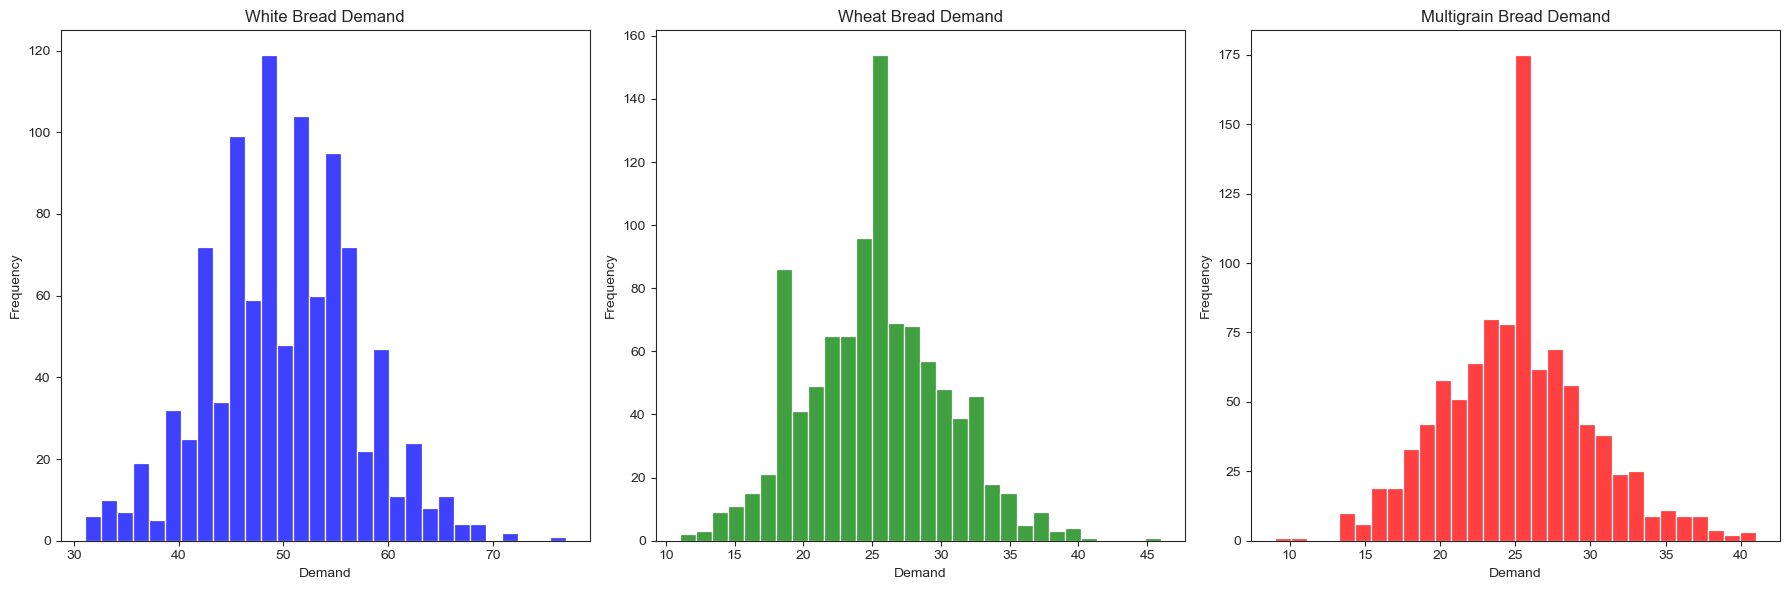

In [5]:
def bread_demand_overdays(mean_arrival_rate, choices, probabilities, days=1000):
    demand_white = []
    demand_wheat = []
    demand_multigrain = []

    for _ in range(days):
        arrivals = customer_arrivals(mean_arrival_rate)
        choices_made = bread_choice(arrivals, choices, probabilities)

        demand_white.append(np.sum(choices_made == 'white'))
        demand_wheat.append(np.sum(choices_made == 'wheat'))
        demand_multigrain.append(np.sum(choices_made == 'multigrain'))

    return demand_white, demand_wheat, demand_multigrain

# Define the choices and probabilities
choices = ['white', 'wheat', 'multigrain']
probabilities = [0.5, 0.25, 0.25]

# Simulate bread demand over 1,000 days
mean_arrival_rate = 100
demand_white, demand_wheat, demand_multigrain = bread_demand_overdays(
    mean_arrival_rate, choices, probabilities)

# Plot histograms for each bread type
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(demand_white, kde=False, bins=30, color='blue')
plt.title('White Bread Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(demand_wheat, kde=False, bins=30, color='green')
plt.title('Wheat Bread Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(demand_multigrain, kde=False, bins=30, color='red')
plt.title('Multigrain Bread Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

> Recalling that a Poisson distribution approaches the Normal for a large mean arrival rate. Do these histograms appear approximately Normal? Is this behavior expected, given that the distribution is conditional on a Poisson process and a uniformly distributed process?   

> **Answer:**  Yes, these histograms approximate a normal distribution and this behavior is expected given the large 1000 days sample size.        

 
### Simulate Bread Baked

The number of each type of bread baked in the sandwich shop is deterministic. The shop manager has a plan for the day, and the bread is baked in advance of the customer's arrival. Naturally, the manager will choose the proportion of each bread type based on the historical expected demand. This is a decision function. The decision to be made is how many total loaves to bake?    

> **Exercise 10-6:** Create a function `bread_baked` with arguments, the total number of loaves, the proportion of each bread type to bake, and the types of bread. The function will return a Pandas series with the number of each type of bread baked, and with index being bread type. Include a simple test case for your function.    

In [6]:
def bread_baked(total_loaves, proportions, bread_types):
    """
    Simulate the number of each type of bread to bake.
    
    Parameters:
    total_loaves (int): Total number of loaves to bake.
    proportions (list of float): Proportion of each bread type to bake.
    bread_types (list of str): The types of bread.
    
    Returns:
    pd.Series: A series with the number of each type of bread to bake.
    """
    baked_counts = np.round(np.array(proportions) * total_loaves).astype(int)
    return pd.Series(baked_counts, index=bread_types)

# Test case for bread_baked function
total_loaves = 100
proportions = [0.5, 0.3, 0.2]
bread_types = ['white', 'wheat', 'multigrain']

baked_bread = bread_baked(total_loaves, proportions, bread_types)
baked_bread

white         50
wheat         30
multigrain    20
dtype: int64

> Is the result of the bread baked function deterministic and is the behavior expected for this variable and why?   

> **Answer:**  Yes it is deterministic. This is expected given the deterministic nature of the variable and the deterministic implementation.

### Simulate and plot profit

The last function you need to execute the full model represented by the DAG computes the daily profit. This function is therefore the utility function. The calculation is deterministic, given the inputs of bread demand and the amount of bread baked. But don't be confused, while the utility function is deterministic, the bread demands is stochastic. As a result, profit is a random variable.

> **Exercise 10-7:** You will now write the function, `daily_profit`, that computes and returns the daily profit. The function calls the `bread_demand` and `bread_baked` functions. Your function will have the following characteristics:      
> 1. The arguments to this function are:     
>   - The daily total of bread baked,    
>   - Proportion of each bread type baked daily,    
>   - Mean daily arrival rate,    
>   - Probabilities of bread choices,    
>   - Amount earned per sandwich sold,   
>   - Cost of discarded bread,    
>   - Bread choices. 
> 2. Bread demand and supply by type are computed using the function you have already created.       
> 3. Iterate over the bread types and compute if there is left-over bread of that type. Then compute profit based on the cases if excess demand (limited by bread supply) or excess bread (cost of disposal) to compute the daily profit. 
> 4. Return the daily profit. 
> Include and execute code to test your function.  

In [7]:
def daily_profit(total_loaves, proportions, 
                 bread_types, mean_arrival_rate, probabilities,
                 earned_per_sandwich, cost_per_discarded_bread):

    # Compute the bread baked for the day
    baked_bread = bread_baked(total_loaves, proportions, bread_types)
    
    # Bread demand for the day
    demand = bread_demand(mean_arrival_rate, bread_types, probabilities)
    
    # Initialize profit
    profit = 0
    
    # Compute profit for each bread type
    for i, bread in enumerate(bread_types):
        
        # Calculate the number of sandwiches sold
        sandwiches_sold = min(demand[i], baked_bread[i])
        
        # Calculate the profit from sold sandwiches
        profit += sandwiches_sold * earned_per_sandwich
        
        # Calculate the cost of discarded bread (if any)
        if baked_bread[i] > demand[i]:
            discarded_bread = baked_bread[i] - demand[i]
            profit -= discarded_bread * cost_per_discarded_bread
    
    return profit

# Test cases for daily_profit function
total_loaves = 100
proportions = [0.5, 0.3, 0.2]
bread_types = ['white', 'wheat', 'multigrain']
mean_arrival_rate = 100
probabilities = [0.5, 0.25, 0.25]
earned_per_sandwich = 5.00
cost_per_discarded_bread = 0.25  # $0.25 per discarded loaf

# Compute the daily profit
profit = daily_profit(total_loaves, proportions, 
                      bread_types, mean_arrival_rate, probabilities, 
                      earned_per_sandwich, cost_per_discarded_bread)
print(f"Daily Profit: ${profit:.2f}")


Daily Profit: $463.25


/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sandwiches_sold = min(demand[i], baked_bread[i])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if baked_bread[i] > demand[i]:
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

> Keeping in mind that the maximum profit is the number of sandwiches sold times the profit per sandwich less the cost of bread, does the value computed make sense and why?    

> **Answer:**   Yes, it is within the maximum and will always fall within the maximum.
>
> Note that the instructions did not specify to separate cost of sandwiches and instead gives a direct amount earned (profit) per sandwich sold, then subtracts costs of sandwiches not sold and discarded only.       

> **Exercise 10-8:** The distribution of daily profit is, as yet, unknown. Further, you will need to test your `daily_profit` function. In order to work towad these goals, you will now simulate 4 year's (1000 business days) profits and plot the result as a histogram. Use a mean arrival rate of 100 and 100 breads baked per day.    

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sandwiches_sold = min(demand[i], baked_bread[i])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if baked_bread[i] > demand[i]:
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

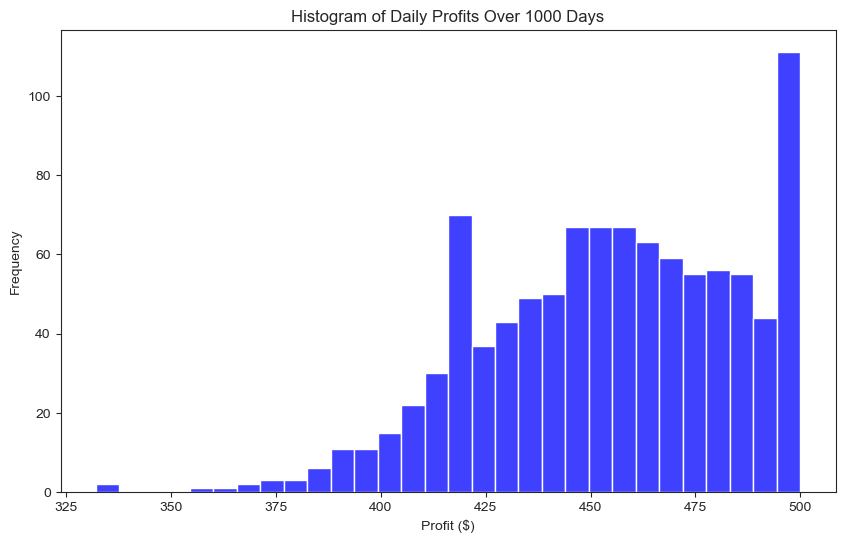

In [8]:
# Simulate profits for 1,000 business days
profits = []
for _ in range(1000):
    profit = daily_profit(total_loaves, proportions, bread_types, 
                          mean_arrival_rate, probabilities, earned_per_sandwich, 
                          cost_per_discarded_bread)
    profits.append(profit)

# Plot the histogram of daily profits
plt.figure(figsize=(10, 6))
sns.histplot(profits, bins=30, kde=False, color='blue')
plt.title("Histogram of Daily Profits Over 1000 Days")
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.show()


> Examine your histogram and answer these questions:       
> 1. Does the distribution of profit resemble the distribution of arrivals or the distribution of bread baked?    
> 2. Does the sharp cut-off at a maximum make sense to give the problem?       
> 3. Do the characteristics of this distribution indicate that it can only be found by a computational method? 

 > **Answers:**     
 > 1. The distribution of profit is likely to resemble the distribution of bread demand, as the profit is directly influenced by the number of sandwiches sold, which in turn depends on the demand. However, since profit also considers the cost of discarded bread, it might not perfectly mirror the distribution of demand or bread baked, but rather a combination of both.       
 > 2. Yes, the sharp cut-off at a maximum profit level makes sense because there’s a maximum number of sandwiches that can be sold, which is limited by the number of loaves baked and the demand.         
 > 3.  Yes, the stochastic nature of customer arrivals and bread choices, combined with the interaction between demand and supply, makes this a problem well-suited to computational simulation. The resulting profit distribution would not be easily obtained purely analytically.           

### Stochastic Nature of Simulation

The key question of interest to the manager of the sandwich shop is the number of loaves of bread to bake to simulate profitability. Thus, there is only one decision variable in this case. We should be able to search a reasonable space of values to find the one which optimizes the profit of the shop.  

But, there is still the issue of how much the results of this simulation vary from run to run. This means, there is considerable uncertainty or variability in the daily profit. Running a simulation multiple times yields the **posterior distribution** of the variables being simulated. In this case we are interested in the posterior distribution of the profitability vs. the number of breads baked. 

> **Exercise 10-9:** Running the simulation of daily profit for different numbers of bread baked will help to quantify the choice and uncertainty in the number of bread to bake each day. You will perform the simulations for 4 business years (1000 days) and for number of bread baked $= [60, 80, 100, 120, 140, 160]$, using the same proportions as before. For each quantity of bread baked you will do the following:     
> 1. Create an empty Pandas data frame columns, `num_baked`, and `profit`. The number of rows is the product of the number of bread baked by the number of realizations of profit for each quantity of bread baked, `index=range(len(num_bread_baked * num_realizations))`.    
> 2. Iterate over the number of bread baked. For each number of breads, compute 1000 realizations of customer arrivals along with the daily profit for the sandwich shop.    
> 3. Create a box plot showing the realizations of profit on the vertical axis and the number of breads baked on the horizontal axis.   
> 4. Display the result of grouping the data frame by `num_baked` and then apply the `describe` method.     


/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sandwiches_sold = min(demand[i], baked_bread[i])
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if baked_bread[i] > demand[i]:
/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_21846/1715996827.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

           profit                      
            count unique     top   freq
num_baked                              
60         1000.0    6.0  300.00  925.0
80         1000.0   17.0  400.00  563.0
100        1000.0   32.0  463.25   83.0
120        1000.0   44.0  484.50   50.0
140        1000.0   58.0  469.00   52.0
160        1000.0   57.0  490.25   49.0


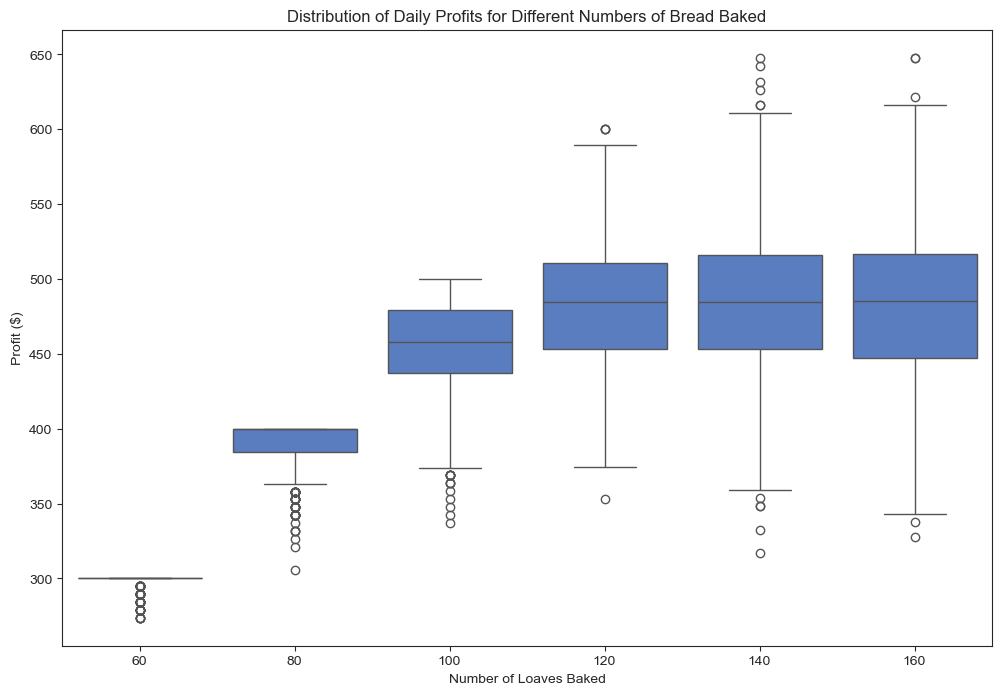

In [9]:
# Define function to simulate profits
def simulate_profits_for_varied_bread(total_loaves_range, proportions, bread_types,
                                      mean_arrival_rate, probabilities, price_per_sandwich, 
                                      cost_per_discarded_bread, num_realizations=1000):

    # empty DataFrame holder
    results = pd.DataFrame(columns=['num_baked', 'profit'], index=range(
        len(total_loaves_range) * num_realizations))
    
    row_idx = 0
    
    # Iterate over the number of bread baked
    for total_loaves in total_loaves_range:
        for _ in range(num_realizations):
            profit = daily_profit(total_loaves, proportions, bread_types, 
                                  mean_arrival_rate, probabilities, price_per_sandwich,
                                  cost_per_discarded_bread)
            # Store the results in the DataFrame
            results.loc[row_idx] = [total_loaves, profit]
            row_idx += 1
    
    return results

# Define parameters
total_loaves_range = [60, 80, 100, 120, 140, 160]
proportions = [0.5, 0.3, 0.2]
bread_types = ['white', 'wheat', 'multigrain']
mean_arrival_rate = 100
probabilities = [0.5, 0.25, 0.25]
price_per_sandwich = 5.00 
cost_per_discarded_bread = 0.25  # $0.25 per discarded loaf

# Simulate profits
simulation_results = simulate_profits_for_varied_bread(total_loaves_range, 
                                                       proportions, bread_types, 
                                                       mean_arrival_rate, probabilities, 
                                                       price_per_sandwich, 
                                                       cost_per_discarded_bread)

# Display the summary statistics grouped by the number of loaves baked
grouped_results = simulation_results.groupby('num_baked').describe()
print(grouped_results)

# Plot the results
plt.figure(figsize=(12, 8))
sns.boxplot(x='num_baked', y='profit', data=simulation_results)
plt.title('Distribution of Daily Profits for Different Numbers of Bread Baked')
plt.xlabel('Number of Loaves Baked')
plt.ylabel('Profit ($)')
plt.show()

> Answer these questions:      
> 1. How does the variability of daily profit change with the number of breads baked?     
> 2. Which number of bread baked have the highest mean and median daily profits, and do you think the difference with the next highest is significant?    
> 3. Given these mean and median values and the risk of low daily profits seen in the variability, which a number of bread baked should the shop manager choose and why?  

> **Answers:**    
> 1. The variability of daily profit increases as the number of breads baked increases. This is evident in the wider spread of the box plots for higher quantities of bread, particularly at 120 and 140 loaves. This is because as more bread is baked, the risk of overproduction (and thus higher waste costs) increases, leading to greater variability in profit.               
> 2.  The highest mean and median daily profits are observed when 120 loaves are baked. The difference between baking 120 loaves and the next highest (likely at 100 loaves) appears to be significant (not rigorously tested though possible).             
> 3.  The shop manager should consider baking 120 loaves. Although this quantity has slightly more variability than baking 100 loaves, it consistently provides the highest median profit, with 140 and 160 having only slighly more but significantly more variability.

## Extensions of the Simulation   

The foregoing simulation has given some insight into the relationship between bread baked and the profitability of the sandwich shop. But of course, the real world is much more complicated. Some examples of real-world complexity that could be accounted for in a more complete simulation include:      
- The arrival rate of customers may change with the day of the week or the season of the year.   
- Other inventory items, besides bread, that are also perishable and have costs.    
- The labor costs for the shop can be variable depending on a finer grain time scale. For example, if most customers arrive within a short window of time more employees are required to meet the surge in demand.     

> **Exercise 10-10:** Consider some other real-world complications which could be accounted for in a more complete simulation. What are they? How could you model these factors?    

> **Answer:**
>
> 1. The arrival rate of customers may vary depending on the day of the week or the season. For instance, a sandwich shop might see more customers during weekdays compared to weekends or during certain times of the year (e.g., holidays and long weekends). We could potentially modify poisson arrival rates to reflect this or use time series data.
>
> 2. Costs are simplified and there will be more perishable items than just bread. Dynamic staffing costs are also ignored. We can implement more detailed variables and probabilities of say supply chain disruptions as well to model these factors.


## Bibliography 

#### Copyright 2020, 2021, 2022, 2023 Stephen F Elston. All rights reserved. 